**ANALIZA PODATKOV O NEPREMIČNINAH NA TRGU**

Najprej naložimo ustrezne knjižnice:

In [115]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_rows = 13
%matplotlib notebook

Naložimo podatke, ki jih bomo analizirali:

In [36]:
pot_oglasi = os.path.join('podatki_nepremicnine','nepremicnine.csv')
pot_regije = os.path.join('podatki_nepremicnine','regije.csv')
oglasi = pd.read_csv(pot_oglasi, index_col='id')
regije = pd.read_csv(pot_regije, index_col='indeks')

Za lažjo primerjavo cen stanovanj bomo najprej izračunali ceno na kvadratni meter za vsako stanovanje.

In [144]:
oglasi['cena_na_m2'] = oglasi.cena / oglasi.velikost

**Analiza cene stanovanj po regijah**

Da bodo grafi bolj pregledni, tabeli dodajmo še stolpec z imeni regij, v katerih se nahajajo stanovanja. To naredimo z združevanjem tabele s tabelo regij.

In [145]:
oglasi_z_regijami = pd.merge(oglasi, regije, left_on='regija', right_on='indeks', suffixes=('_indeks', '_ime'))

Poglejmo si najprej, koliko stanovanj je naprodaj v posamezni regiji:

<IPython.core.display.Javascript object>


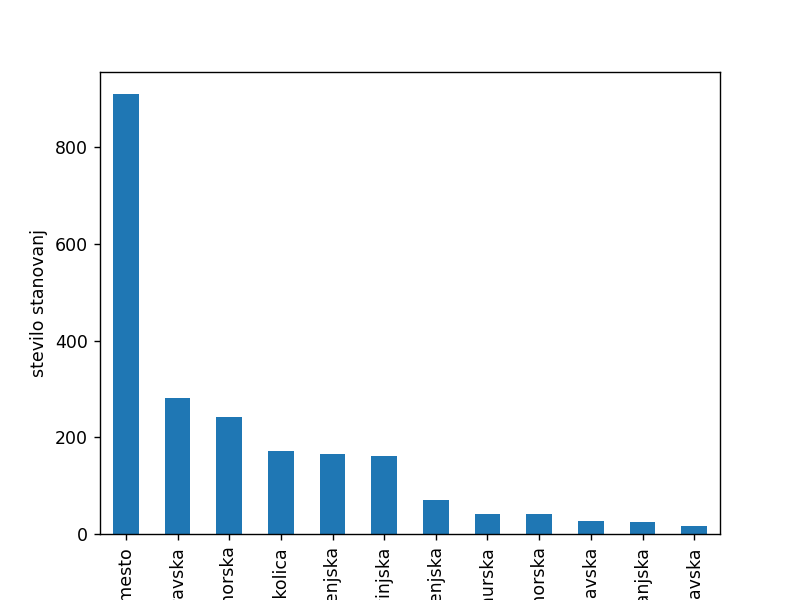

<AxesSubplot:xlabel='regija_ime', ylabel='stevilo stanovanj'>

In [119]:
oglasi_z_regijami.groupby('regija_ime').size().sort_values(ascending=False).plot.bar(xlabel='regija', ylabel='stevilo stanovanj')

Primerjajmo še povprečne cene stanovanj na kvadratni meter med posameznimi regijami:

<IPython.core.display.Javascript object>


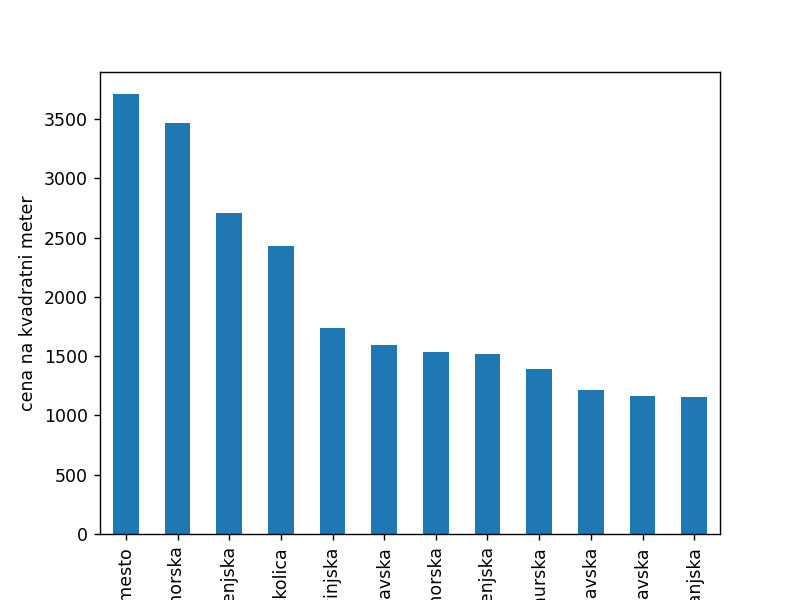

<AxesSubplot:xlabel='regija', ylabel='cena na kvadratni meter'>

In [146]:
oglasi_z_regijami.groupby('regija_ime').mean().sort_values('cena_na_m2', ascending=False).cena_na_m2.plot.bar(xlabel='regija', ylabel='cena na kvadratni meter')

**Relativna cena stanovanj glede na velikost**

Naša hipoteza je, da so manjša stanovanja dražja glede na kvadratni meter. To bomo preverili z naslednjim diagramom, ki prikazuje odvisnost med velikostjo stanovanja in njegovo ceno na kvadratni meter. Ker so nekateri nereprezentativni podatki uničevali kakovost diagrama, sem velikost omejila na 800 m^2.

<IPython.core.display.Javascript object>


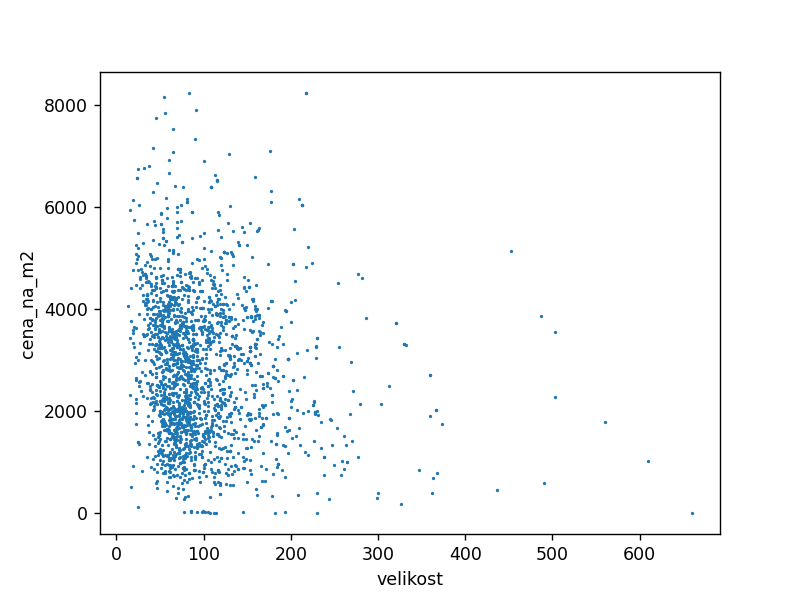

<AxesSubplot:xlabel='velikost', ylabel='cena_na_m2'>

In [148]:
oglasi[oglasi.velikost < 800].sort_values('velikost').plot.scatter(x='velikost', y='cena_na_m2', s=0.8)

Vidimo, da je pri velikih stanovanjih cena na kvadratni meter v povprečju nižja kot pri majnih. Cene pri majhnih stanovanjih pa se med sabo zelo razlikujejo.

Ker pa je pomemben podatek o velikosti in razporejenosti prostorov tudi to, koliko sob ima stanovanje, nas zanima tudi, ali cena na kvadratni meter pade pri večsobnih stanovanjih, oziroma ali so garsonjere res najdražje glede na kvadratni meter.

<IPython.core.display.Javascript object>


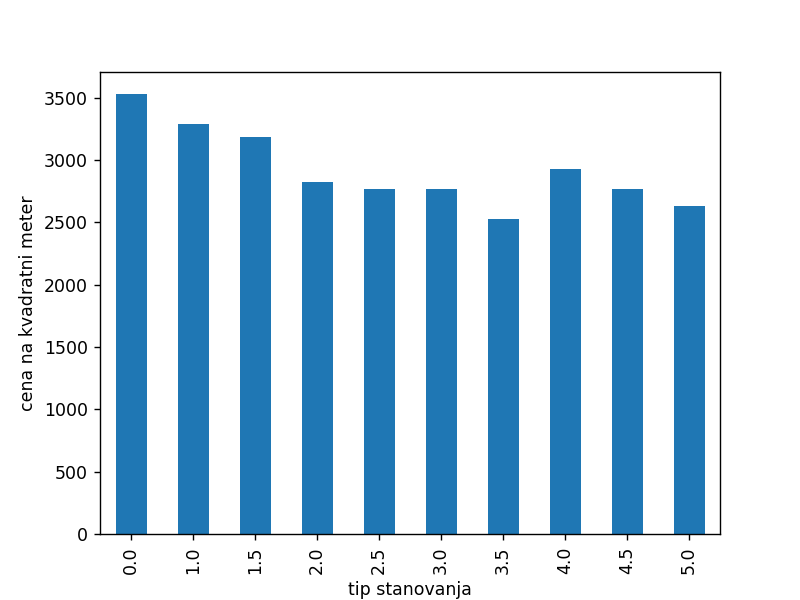

<AxesSubplot:xlabel='tip stanovanja', ylabel='cena na kvadratni meter'>

In [149]:
oglasi.groupby('tip').mean().cena_na_m2.plot.bar(xlabel='tip stanovanja', ylabel='cena na kvadratni meter')

Iz diagrama je razvidno, da so v razmerju z velikostjo najdražja majhna stanovanja, najcenejša pa srednje velika stanovanja, ki jih je verjetno tudi največ na trgu.

**Cena v odvisnosti od leta izgradnje in obnove**

Zanima nas, ali leto izgradnje močno vpliva na ceno stanovanja. Za lažjo analizo bomo stanovanja razdelili na skupine po desetletjih in vzeli njihovo povprečje.

In [123]:
oglasi['desetletje'] = oglasi.leto // 10 * 10

Sedaj lahko stanovanja razdelimo na posamezne skupine in izračunamo povprečje:

<IPython.core.display.Javascript object>


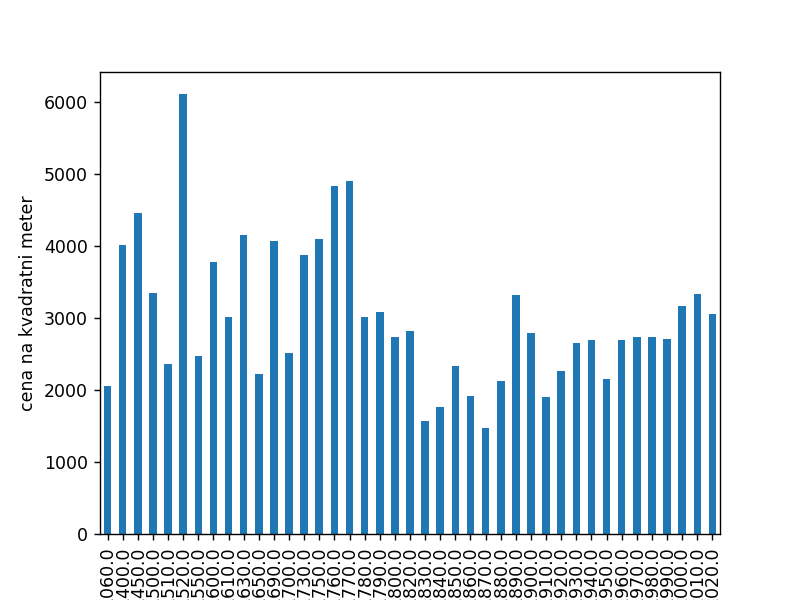

<AxesSubplot:xlabel='desetletje', ylabel='cena na kvadratni meter'>

In [126]:
oglasi.groupby('desetletje').mean().cena_na_m2.plot.bar(xlabel='desetletje', ylabel='cena na kvadratni meter')

Vidimo, da novejša stanovanja v povprečju niso dražja od starih, kar je presenetljivo. Zato preverimo še kdaj so bila stara stanovanja obnovljena. To bomo dosegli z ustrezno nastavljenimi vrednostmi za obnovo pri tistih oglasih, ki podatka o obnovi nimajo. S tem namenom bomo podatkom dodali stolpec, v katerem bo leto zadnjega dela na objektu. Če je bilo stanovanje obnovljeno, bo to torej leto obnove, sicer pa leto izgradnje.

In [127]:
oglasi['obnova'] = oglasi['obnova'].fillna(0)
oglasi['zadnja_dela'] = oglasi[['leto', 'obnova']].max(axis=1)

Zdaj lahko podobno analizo cene glede na desetletje izvedemo z novimi podatki o delih na stanovanju. Manjka nam le še stolpec z desetletjem zadnjega dela.

In [128]:
oglasi['desetletje_dela'] = oglasi.zadnja_dela // 10 * 10

<IPython.core.display.Javascript object>


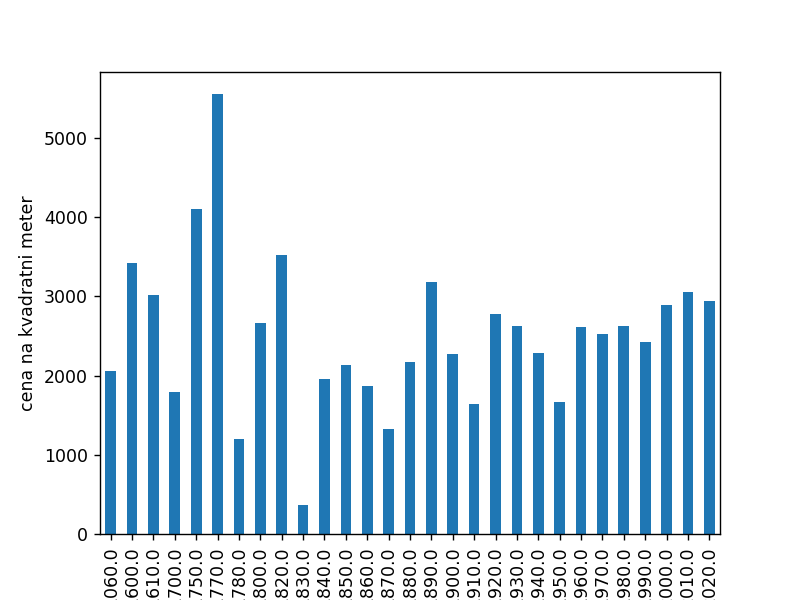

<AxesSubplot:xlabel='desetletje zadnjega dela', ylabel='cena na kvadratni meter'>

In [130]:
oglasi.groupby('desetletje_dela').mean().cena_na_m2.plot.bar(xlabel='desetletje zadnjega dela', ylabel='cena na kvadratni meter')

Iz zgornjega diagrama je razvidno, da naše hipoteze ne potrjuje. Vidimo, da so podatki za zelo stara stanovanja precej nekonstantni, kar je verjetno posledica pomanjkanja informacij o obnovi. Osredotočimo se zato le na stanovanja, ki so bila zgrajena oziroma obnovljena v 20. ali 21. stoletju.

<IPython.core.display.Javascript object>


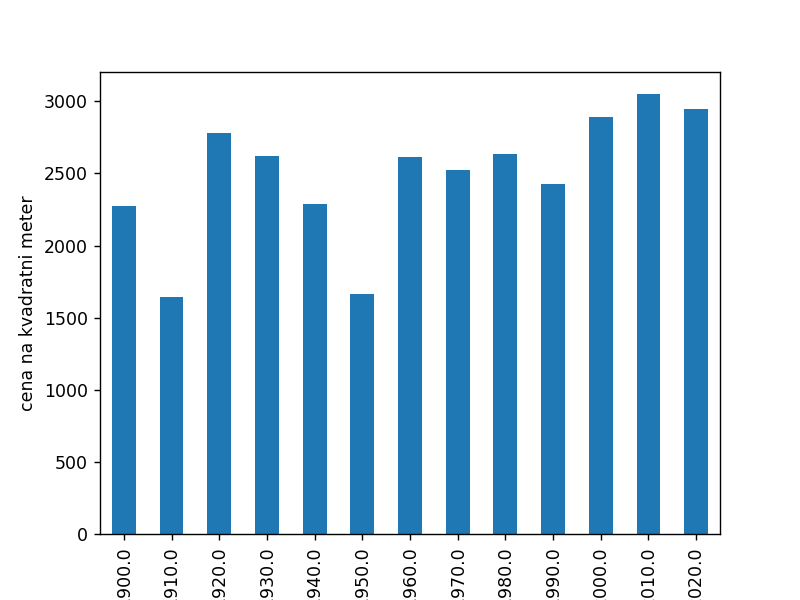

<AxesSubplot:xlabel='desetletje zadnjega dela', ylabel='cena na kvadratni meter'>

In [150]:
oglasi[oglasi.desetletje_dela >= 1900].groupby('desetletje_dela').mean().cena_na_m2.plot.bar(xlabel='desetletje zadnjega dela', ylabel='cena na kvadratni meter')

Vidimo, da so stanovanja iz zadnjih let res najdražja, vendar so razlike veliko manjše, kot bi pričakovali.

**Kako zemljišče vpliva na ceno stanovanja?**

Pod zemljišče spada kakršna koli zunanja površina okoli stavbe, večinoma vrt. Ker je veliko stanovanj brez zemljišča, ne bomo analizirali cene glede na velikost pripadajočega zemljišča , vendar le glede na to ali mu kaj zemljišča pripada ali ne. V ta namen bomo tabeli dodali stolpec, v katerem bo zabeleženo, ali ima stanovanje zemljišče.

In [83]:
oglasi['ima_zemljisce'] = oglasi.zemljisce > 0

Sedaj si oglejmo, ali imajo stanovanja z zemljiščem višjo povprečno ceno na kvadratni meter kot tista brez njega.

<IPython.core.display.Javascript object>


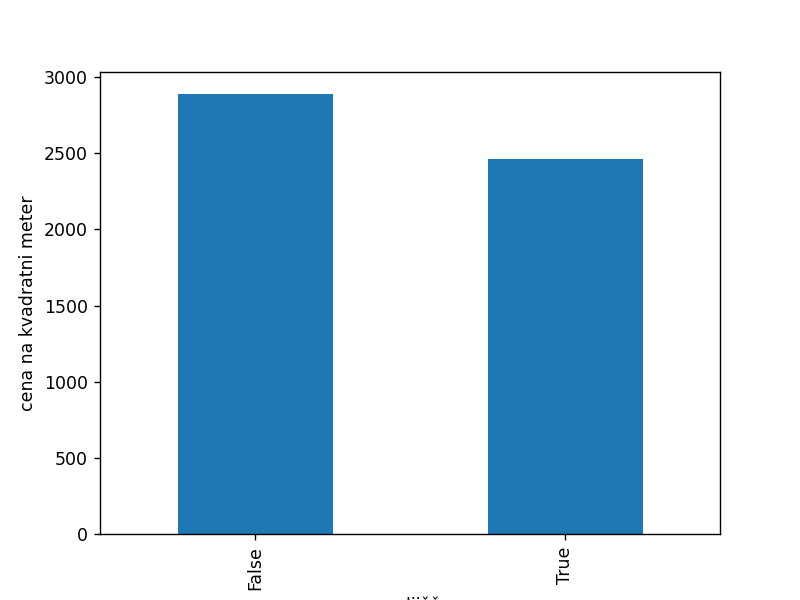

<AxesSubplot:xlabel='zemljišče', ylabel='cena na kvadratni meter'>

In [151]:
oglasi.groupby('ima_zemljisce').mean().cena_na_m2.plot.bar(xlabel='zemljišče', ylabel='cena na kvadratni meter')

V nasprotju z našimi pričakovanji je povprečna cena stanovanja na kvadratni meter pri stanovanjih brez zemljišča višja kot pri stanovanjih z zemljiščem. Verjetno je vzrok za to dejstvo, da so stanovanja v Ljubljani veliko dražja od stanovanj v ostalih regijah, hkrati pa večinoma nimajo zemljišča. Nasploh so stanovanja v mestih praviloma dražja in brez vrtov, zato bi tako statistiko lahko pričakovali.

**Analiza vpliva lastnosti stanovanja na ceno**

Za analiziranje vpliva posameznih lastnosti stanovanja na njegovo ceno na trgu bomo uporabili strojno učenje. Z uporabo knjižnice sklearn in nekaterih njenih modelov bomo dobili pomembnost posameznih spremenljivk pri napovedovanju cene stanovanja in s tem podatke o tem, kaj najbolj vpliva na ceno.

Naredimo najprej tabelo s podatki o stanovanjih, ki so uporabni za strojno učenje. Poleg tega bomo potrebovali tabelo s cenami, ki bo predstavljala ciljno vrednost, ki jo bo računalnik napovedoval.

In [132]:
oglasi_ML = oglasi[['regija', 'velikost', 'zemljisce', 'tip', 'leto', 'zadnja_dela']]
oglasi_cene = oglasi['cena'].fillna(0)

Uporabili bomo tri različne modele, ki se bodo učili na naših podatkih in njihove rezultate med sabo primerjali. Najprej zato definirajmo modele (za kar pa moramo tudi naložiti ustrezne knjižnice).

In [52]:
drevo = tree.DecisionTreeRegressor(max_depth = 3)
GBR = GradientBoostingRegressor(learning_rate=1)
RFR = RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state=1)

Preden ustavrjene modele uporabimo na naših podatkih, moramo podatke še prilagoditi. Znebiti se moramo vrednosti *Nan* in diskretne vrednosti razdeliti na binarne vrednosti. Za diskretne vrednosti bomo šteli le regije, ker je tip stanovanja povezan z njegovo velikostjo, ki pa je zvezna spremenjlivka. Vrednosti *Nan* se pojavljajo le pri podatkih o zemljišču in o letu obnove. Namesto vrednosti *Nan* pri velikostih zemljišča lahko vstavimo kar 0, saj stanovanja brez podatka o velikosti zemljišča najverjetneje nimajo zemljišča. Namesto stolpca z letom obnove pa lahko vzamemo stolpec zadnja_dela, ki je brez vrednosti *Nan* in predstavlja leto obnove (oziroma izgradnje, če objekt še ni bil obnovljen).

In [134]:
podatki = pd.get_dummies(oglasi_ML, columns=['regija'])
podatki = podatki.fillna(0)

Podatki so sedaj pripravljeni za analizo, zato jih lahko uporabimo za učenje modelov. Po končanem učenju pa od modelov dobimo pomembnost posameznih parametrov pri njihovi odločitvi.

Model RandomForestRegressor:

<IPython.core.display.Javascript object>


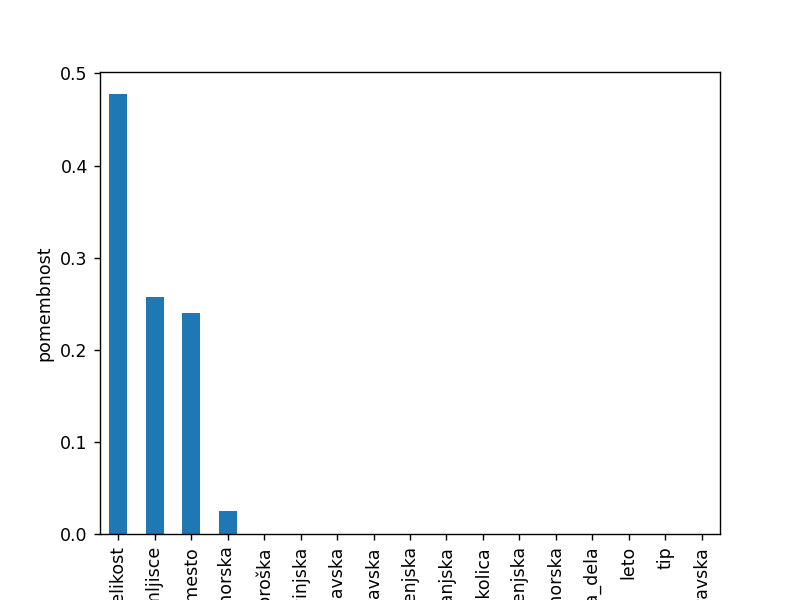

<AxesSubplot:xlabel='lastnosti', ylabel='pomembnost'>

In [135]:
drevo_fit = drevo.fit(podatki, oglasi_cene)
feat_importances = pd.Series(drevo_fit.feature_importances_, index=['velikost', 'zemljisce', 'tip', 'leto', 'zadnja_dela', 'severna-primorska', 'gorenjska', 'juzna-primorska', 'notranjska', 'ljubljana-okolica', 'ljubljana-mesto', 'dolenjska', 'posavska', 'zasavska', 'savinjska', 'koroška', 'podravska'])
feat_importances.sort_values(ascending=False).plot.bar(xlabel='lastnosti', ylabel='pomembnost')

GradientBoostingRegressor:

<IPython.core.display.Javascript object>


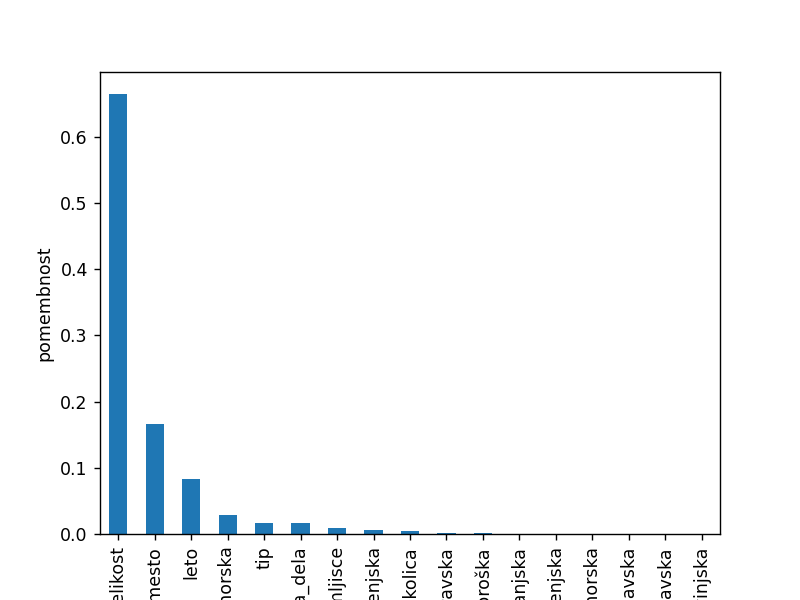

<AxesSubplot:xlabel='lastnosti', ylabel='pomembnost'>

In [136]:
GBR_fit = GBR.fit(podatki, oglasi_cene)
feat_importances = pd.Series(GBR_fit.feature_importances_, index=['velikost', 'zemljisce', 'tip', 'leto', 'zadnja_dela', 'severna-primorska', 'gorenjska', 'juzna-primorska', 'notranjska', 'ljubljana-okolica', 'ljubljana-mesto', 'dolenjska', 'posavska', 'zasavska', 'savinjska', 'koroška', 'podravska'])
feat_importances.sort_values(ascending=False).plot.bar(xlabel='lastnosti', ylabel='pomembnost')

RandomForestRegressor:

<IPython.core.display.Javascript object>


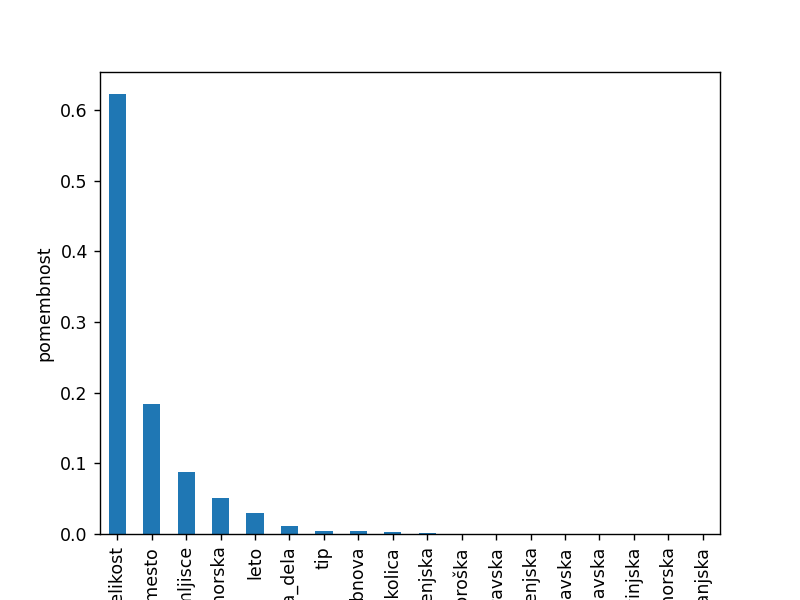

<AxesSubplot:xlabel='lastnosti', ylabel='pomembnost'>

In [72]:
RFR_fit = RFR.fit(podatki, oglasi_cene)
feat_importances = pd.Series(RFR_fit.feature_importances_, index=['velikost', 'zemljisce', 'tip', 'leto', 'obnova', 'zadnja_dela', 'severna-primorska', 'gorenjska', 'juzna-primorska', 'notranjska', 'ljubljana-okolica', 'ljubljana-mesto', 'dolenjska', 'posavska', 'zasavska', 'savinjska', 'koroška', 'podravska'])
feat_importances.sort_values(ascending=False).plot.bar(xlabel='lastnosti', ylabel='pomembnost')

Očitno je, da pri vseh treh modelih največjo vlogo igra velikost stanovanja, kar je pričakovano. Ker pa nas zanimajo tudi ostali parametri, analizirajmo podatke še enkrat, tokrat brez podatka o velikosti stanovanja.

In [138]:
podatki_brez_velikosti = podatki.drop(['velikost'], axis=1)

DecisionTreeRegressor:

<IPython.core.display.Javascript object>


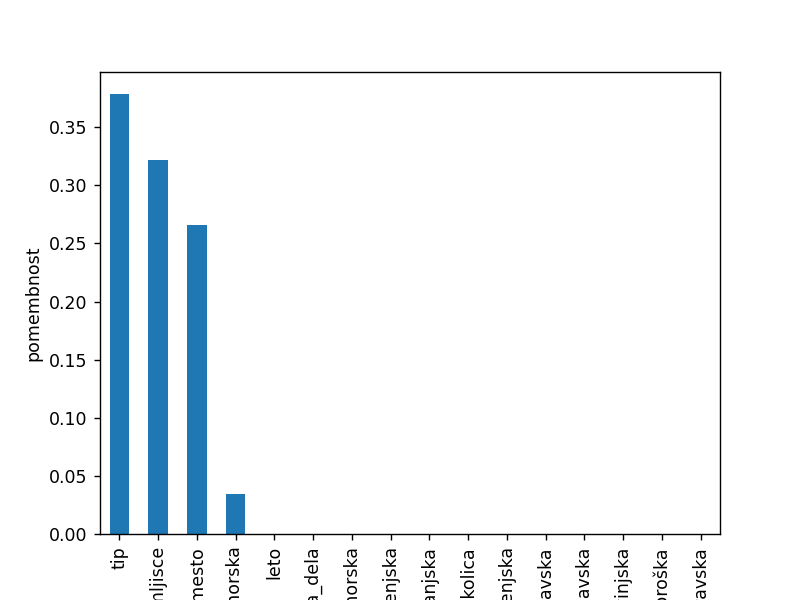

<AxesSubplot:xlabel='lastnosti', ylabel='pomembnost'>

In [139]:
drevo_fit = drevo.fit(podatki_brez_velikosti, oglasi_cene)
feat_importances = pd.Series(drevo_fit.feature_importances_, index=['zemljisce', 'tip', 'leto', 'zadnja_dela', 'severna-primorska', 'gorenjska', 'juzna-primorska', 'notranjska', 'ljubljana-okolica', 'ljubljana-mesto', 'dolenjska', 'posavska', 'zasavska', 'savinjska', 'koroška', 'podravska'])
feat_importances.sort_values(ascending=False).plot.bar(xlabel='lastnosti', ylabel='pomembnost')

GradientBoostingRegressor:

<IPython.core.display.Javascript object>


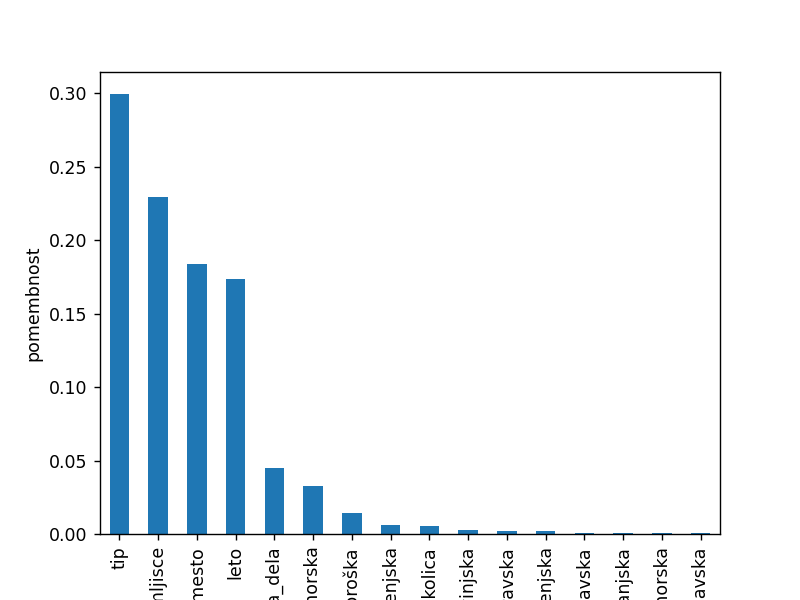

<AxesSubplot:xlabel='lastnosti', ylabel='pomembnost'>

In [140]:
GBR_fit = GBR.fit(podatki_brez_velikosti, oglasi_cene)
feat_importances = pd.Series(GBR_fit.feature_importances_, index=['zemljisce', 'tip', 'leto', 'zadnja_dela', 'severna-primorska', 'gorenjska', 'juzna-primorska', 'notranjska', 'ljubljana-okolica', 'ljubljana-mesto', 'dolenjska', 'posavska', 'zasavska', 'savinjska', 'koroška', 'podravska'])
feat_importances.sort_values(ascending=False).plot.bar(xlabel='lastnosti', ylabel='pomembnost')

RandomForestRegressor:

<IPython.core.display.Javascript object>


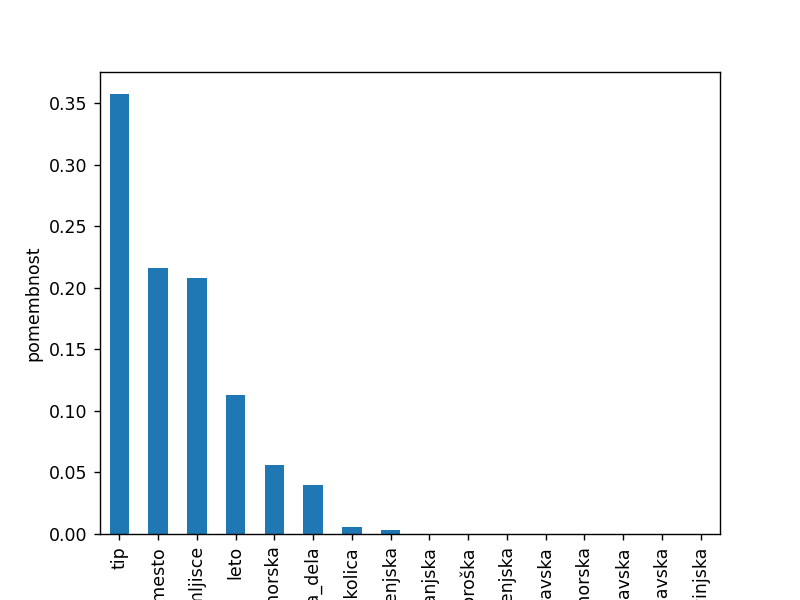

<AxesSubplot:xlabel='lastnosti', ylabel='pomembnost'>

In [141]:
RFR_fit = RFR.fit(podatki_brez_velikosti, oglasi_cene)
feat_importances = pd.Series(RFR_fit.feature_importances_, index=['zemljisce', 'tip', 'leto', 'zadnja_dela', 'severna-primorska', 'gorenjska', 'juzna-primorska', 'notranjska', 'ljubljana-okolica', 'ljubljana-mesto', 'dolenjska', 'posavska', 'zasavska', 'savinjska', 'koroška', 'podravska'])
feat_importances.sort_values(ascending=False).plot.bar(xlabel='lastnosti', ylabel='pomembnost')

Vidimo, da je v tem primeru vlogo velikosti prevzel parameter *tip*, ki posredno določa velikost stanovanja. Vendar pa so v ospredju tudi drugi parametri. Med pomembnejšimi so tako tudi to ali je stanovanje v Ljubljani, ali ima zemljišče, kdaj je bilo zgrajeno, ali je na primorskem in kdaj je bilo obnovljeno. 